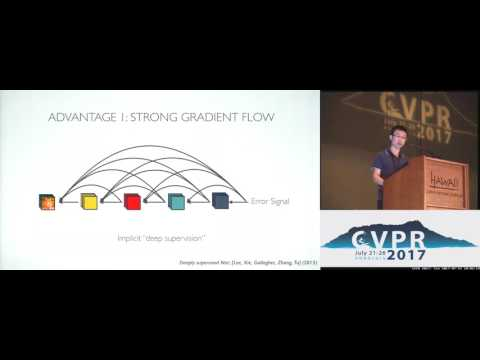

In [1]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [2]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten,Conv2D,Conv1D
from tensorflow.keras.optimizers import Adam
import numpy as np


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

#https://stackoverflow.com/questions/46066850/understanding-the-resourceexhaustederror-oom-when-allocating-tensor-with-shape
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 40
l = 6 # specifying number of layers
num_filter = 35
compression = 1.0
dropout_rate = 0.0
seed = 100

In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 11s 0us/step


In [6]:
print("Train Shape is" + str(X_train.shape))
print("Test Shape is" + str(X_test.shape))

Train Shape is(50000, 32, 32, 3)
Test Shape is(10000, 32, 32, 3)


In [7]:
mean  = np.mean(X_train)
print(mean)
std_deviation = np.std(X_train)
print(std_deviation)
X_train = (X_train - mean) / std_deviation
print(X_train.max())
print(X_train.min())
X_test = (X_test - mean) / std_deviation

120.70756512369792
64.1500758911213
2.09341038199596
-1.8816433721538972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


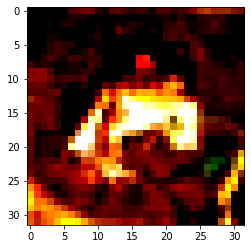

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


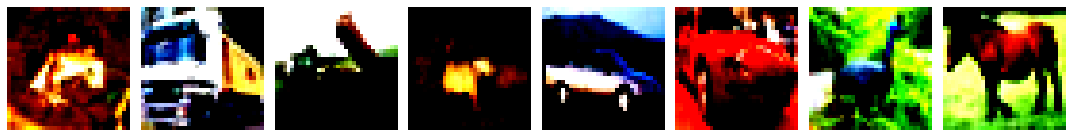

In [9]:
#https://www.tensorflow.org/tutorials/images/classification
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(X_train[:8])

In [10]:
print(X_train.max())
print(X_train.min())

2.09341038199596
-1.8816433721538972


In [0]:
#https://www.kaggle.com/c/cifar-10/discussion/40237
#https://stats.stackexchange.com/questions/272607/cifar-10-cant-get-above-60-accuracy-keras-with-tensorflow-backend
#https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
#https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
# Generator for our training data
#validation_image_generator = ImageDataGenerator(rescale=1./255) 
#X_train = X_train / 255
#X_test = X_test / 255

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

#z-score
#mean = np.mean(X_train,axis=(0,1,2,3))
#std = np.std(X_train,axis=(0,1,2,3))
#X_train = (X_train-mean)/(std+1e-7)
#X_test = (X_test-mean)/(std+1e-7)

In [0]:

#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# Generator for our validation data
train_image_generator  = ImageDataGenerator( 
    zoom_range=0.3,
    rotation_range=25,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    #shear_range = 15,
    #rescale=1./255,
    fill_mode='nearest')

In [0]:
train_image_generator.fit(X_train)

In [0]:
#train_data_gen = train_image_generator.flow(X_train,batch_size=batch_size, seed=seed)
train_data_gen = train_image_generator.flow(X_train,y_train,batch_size=batch_size,shuffle = False)
#validation_data_gen = validation_image_generator.flow(X_test, seed=seed,shuffle = False)

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #https://stackoverflow.com/questions/41161021/how-to-convert-a-dense-layer-to-an-equivalent-convolutional-layer-in-keras
    #https://medium.com/@mein2work/converting-fc-layers-to-conv-layers-8a43880a44ed
    #https://stackoverflow.com/questions/52372980/how-to-replace-dense-layer-with-convolutional-one

    conv_1 = layers.Conv2D(30,kernel_size=[2,2],strides=[1,1],padding='valid',activation = 'relu')(AvgPooling)
    
    output = layers.Conv2D(10,kernel_size=[1,1],strides=[1,1],padding='valid',activation = 'softmax')(conv_1)
    output = layers.Flatten()(output)
    #output = layers.Conv2D(10,kernel_size=[1,1],strides=[1,1],padding='valid',activation = 'relu')(output)
    #target_shape = 10
    #out = layers.Reshape([10,1])
    #conv_out = layers.Conv2D(filters=3,kernel_size=(3,3),activation='softmax')(out)

    #output = layers.Dense(num_classes, activation='softmax')(flat)
    #output =conv_1

    return output

In [16]:
#num_filter = 14
dropout_rate = 0.0
#l = 15
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#Fourth_Block = denseblock(Third_Transition, num_filter, dropout_rate)
#Fourth_Transition = transition(Fourth_Block, num_filter, dropout_rate)

#Fifth_Block = denseblock(Fourth_Transition, num_filter, dropout_rate)
#Fifth_Transition = transition(Fifth_Block, num_filter, dropout_rate)

#Last_Block = denseblock(Fifth_Transition,  num_filter, dropout_rate)
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

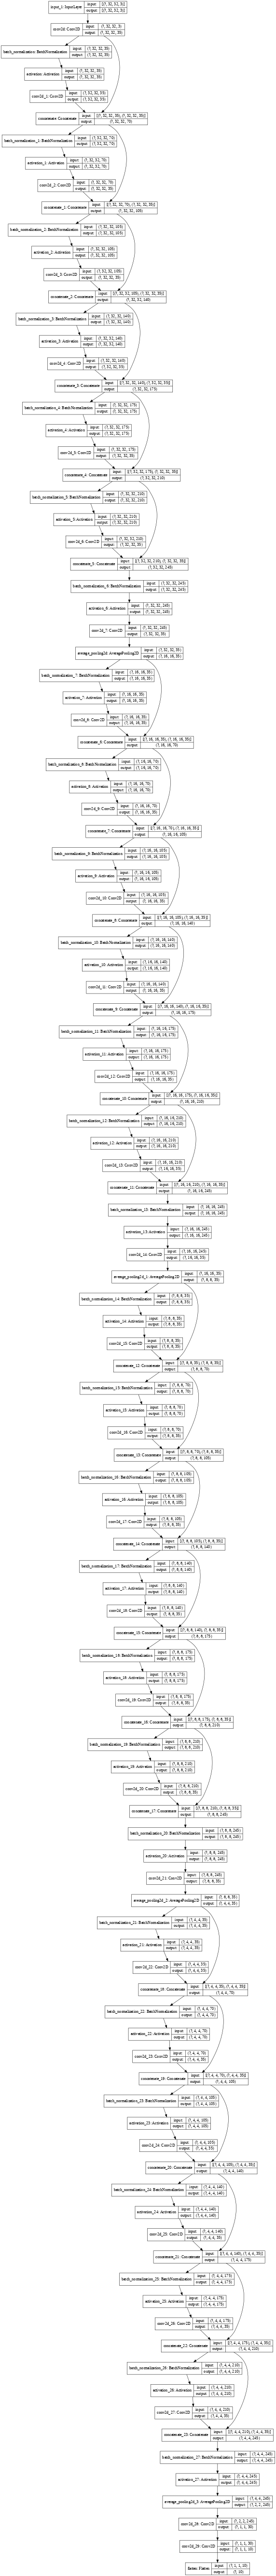

In [18]:
#https://www.tensorflow.org/guide/keras/functional#models_with_multiple_inputs_and_outputs
tf.keras.utils.plot_model(model, 'lstm_model_1.png', show_shapes=True,show_layer_names=True,dpi=40)

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

##https://www.kaggle.com/c/cifar-10/discussion/40237
#opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
#model.compile(loss='categorical_crossentropy',
#        optimizer=opt_rms,
#        metrics=['accuracy'])

In [0]:
#https://stackoverflow.com/questions/48908772/read-csv-with-pandas-from-subdirectory-on-windows-and-unix
#from pathlib import Path
#rom os.path import dirname
#root = Path()

# Include the epoch in the file name (uses `str.format`)
#checkpoint_path = 'checkpoint/cp-{epoch:04d}.ckpt'
#checkpoint_dir = dirname(checkpoint_path)

#checkpoint_dir

# Create a callback that saves the model's weights every 5 epochs
#cp_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_path, 
#    verbose=1, 
#    save_weights_only=True,
#    period=5)

In [0]:
# Save the weights using the `checkpoint_path` format
#model.save_weights(checkpoint_path.format(epoch=0))

In [0]:
#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

In [0]:
ACCURACY_THRESHOLD = 0.90

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
accuracy_over_90_callback = myCallback()

In [0]:
#https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 25:
        lrate = 0.0005
    if epoch > 40:
        lrate = 0.0003
    if epoch> 60:
        lrate = 0.00011
    return lrate

In [25]:
epochs = 40
model.fit_generator(generator = train_data_gen,
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    #batch_size=batch_size,
                    epochs= 2 * epochs,
                    verbose=1, 
                    #callbacks=[cp_callback, accuracy_over_90_callback],
                    callbacks=[ accuracy_over_90_callback,reduce_lr, LearningRateScheduler(lr_schedule)],
                    validation_data=(X_test,y_test)
                    #workers=4
                   )
                    #validation_steps=batch_size

# Save the trained weights in to .h5 format
model.save("DNST_model.h5")
print("Saved model to disk")

Epoch 1/80
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
781/781 [==============================] - 67s 86ms/step - loss: 1.6141 - acc: 0.4092 - val_loss: 1.6740 - val_acc: 0.4404
Epoch 2/80
781/781 [==============================] - 57s 73ms/step - loss: 1.2174 - acc: 0.5610 - val_loss: 1.1959 - val_acc: 0.5911
Epoch 3/80
781/781 [==============================] - 57s 73ms/step - loss: 1.0148 - acc: 0.6375 - val_loss: 0.9848 - val_acc: 0.6507
Epoch 4/80
781/781 [==============================] - 57s 73ms/step - loss: 0.8931 - acc: 0.6845 - val_loss: 0.7764 - val_acc: 0.7331
Epoch 5/80
781/781 [==============================] - 57s 73ms/step - loss: 0.8018 - acc: 0.7191 - val_loss: 0.7150 - val_acc: 0.7540
Epoch 6/80
781/781 [==============================] - 57s 73ms/step - loss: 0.7449 - acc: 0.7401 - val_loss: 0.6457 - val_acc: 0.7831
Epoch 7/80
781/781 [==============================] - 57s 73ms/step - loss: 0.6960 - acc: 0.7577 - val

In [27]:

ouput = model.evaluate(X_test,y_test)

output

10000/10000 [==============================] - 3s 340us/sample - loss: 0.3262 - acc: 0.9001


<tf.Tensor 'flatten/Reshape:0' shape=(?, 10) dtype=float32>

In [29]:
#https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator
# Confusion Matrix
from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test, model.predict(X_test)))

predictions = model.predict(X_test)

y_pred = (predictions > 0.5)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

[[897  22  18   5   2   0   6   4  20  26]
 [  1 976   0   0   0   0   0   1   1  21]
 [ 61   3 857   8  22   7  31   4   2   5]
 [ 70   7  23 717  27  84  49   6   4  13]
 [ 29   0  19   6 904   3  29   8   1   1]
 [ 55   5  12  45  19 832  20   7   0   5]
 [ 12   1   9   4   1   1 969   0   1   2]
 [ 32   1   6   3  23  12   5 912   0   6]
 [ 30  22   4   0   2   0   2   1 916  23]
 [  4  36   0   0   0   0   0   1   5 954]]


# Visualize the model

In [0]:
#https://github.com/sunneysood/Tensorflow/blob/master/Multi_Layer_LSTM.ipynb
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

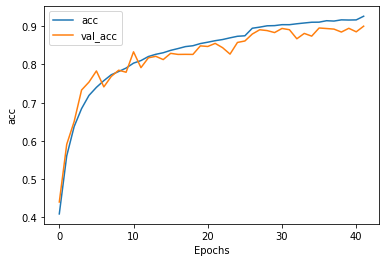

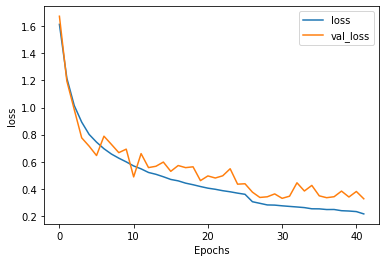

In [28]:
plot_graphs(model.history, 'acc')
plot_graphs(model.history, 'loss')